In [42]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ai_client
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *
from src.agents.news_filtering_agent import *
from src.agents.trading_agent import *

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
coin = "DOGE"

cutoff = subtract_time(get_current_datetime(), days=20)
str(cutoff)

'2024-04-01 11:42:24.382443'

In [132]:
day_history = get_day_history(coin, cutoff)
week_history = get_week_history(coin, cutoff)
month_history = get_month_history(coin, cutoff)
year_history = get_year_history(coin, cutoff)

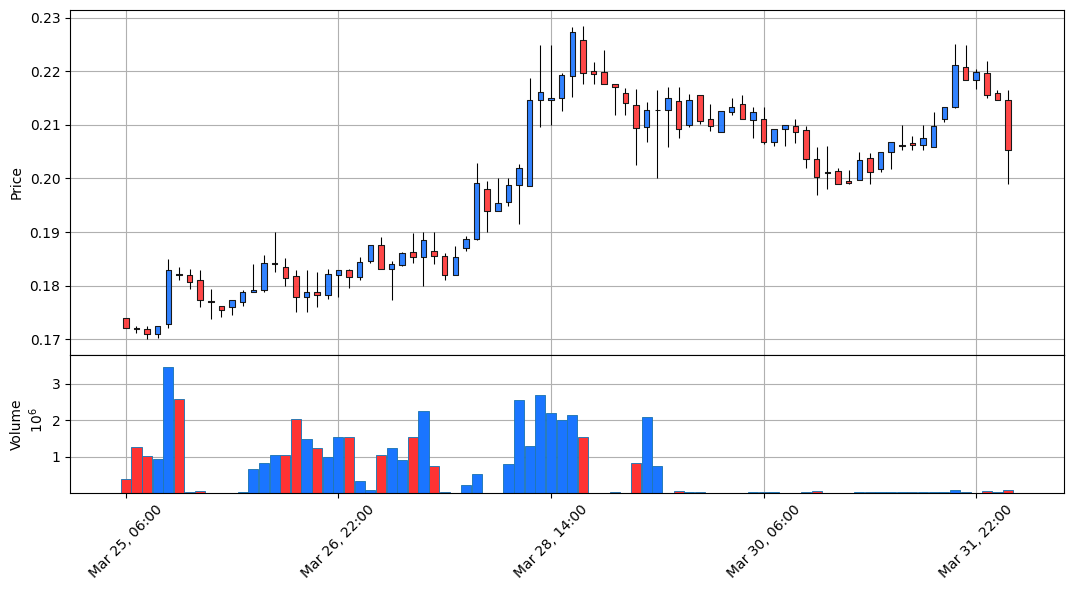

In [133]:
make_candlebars(week_history)

In [134]:
napi = NewsApi()
trading_agent = TradingAgent()
filtering_agent = NewsFilteringAgent()

In [135]:
news = napi.get_news(coin, start_date=subtract_time(cutoff, days=10), end_date=cutoff)
filtered_news = filtering_agent.filter_news(news)
json.loads(filtered_news)

{'headlines': 'Top Crypto Gainers to Watch this Week – Dogecoin, Aptos, Toncoin and New Altcoin ICOs',
 'sentiment': 'Positive',
 'description': 'In recent news, the cryptocurrency market has experienced a correction, but TON coin, alongside other cryptocurrencies like Dogecoin and Aptos, was highlighted in a ReadWrite article as one of the top crypto gainers to watch this week. The market has shown signs of recovery, and TON coin is gaining attention from investors looking for potential growth amidst new altcoin ICOs.'}

In [145]:
balance = {coin: 0, "USDT": 100}
operations_history = []

[{'role': 'system', 'content': "You are professional trader with an extensive understanding of cryptocurrency markets. \n                \n                Respond with JSON of descrived format\n                Guidelines:\n                - Do not buy on everything you have, distribute spendings!\n                - Feel free to sell all if selling improves total net_worth of acccount\n                - Consider historical market data and recent news.\n                - Use only money from your 'balance'\n                - Never close deals resulting in negative balance\n                - Never sell if you will loose money after it\n                \n                Your ultimate goal is to make 3k$\n                "}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of this coin in the last day. Current price: 0.21521'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price 
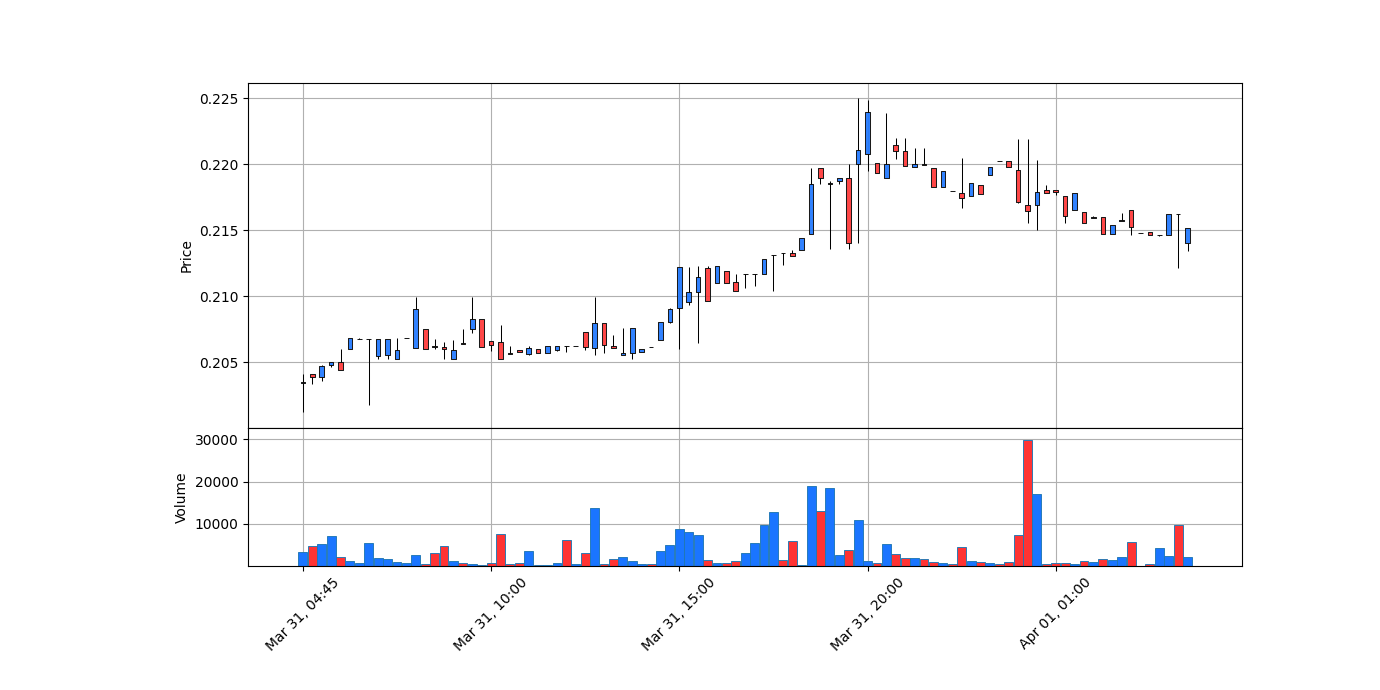
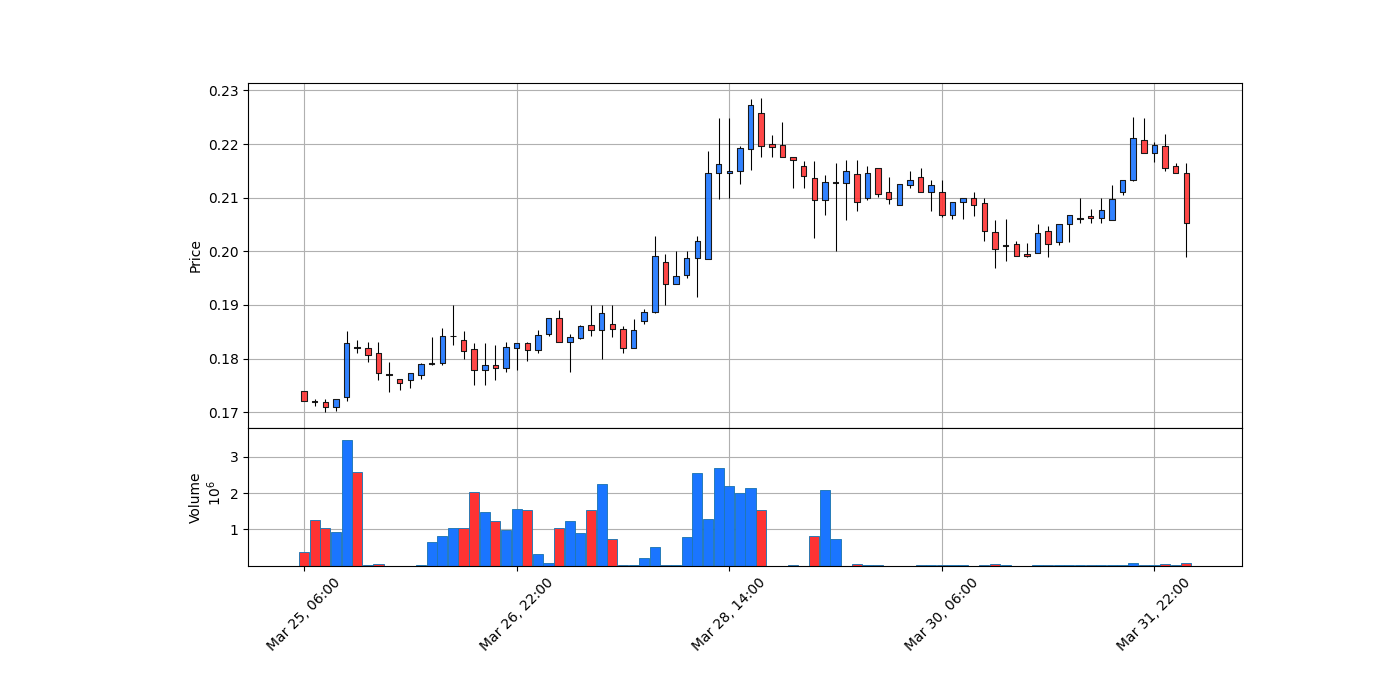
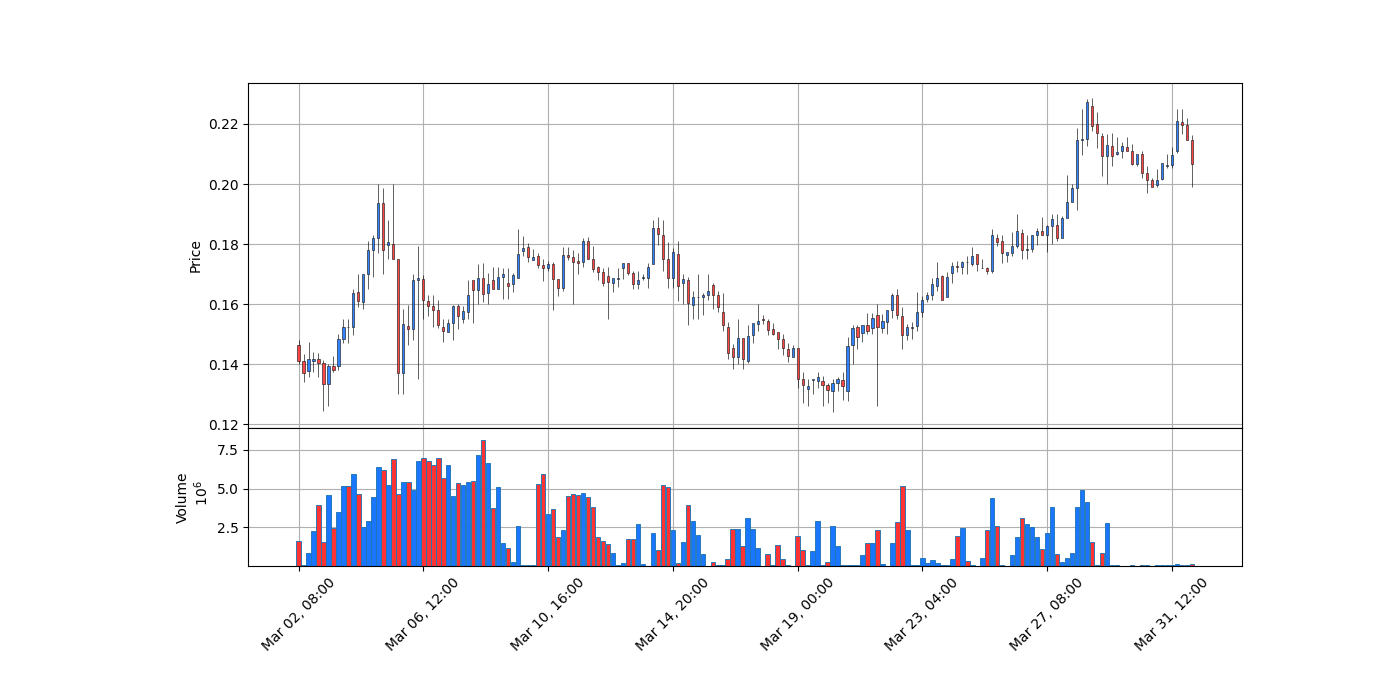

{'trend_analysis': "Reviewing the last day, week, and month's price history of DOGE, there is a general positive upward trend, indicating strength. The recent news sentiment also strongly supports a bullish outlook for growth, especially this week, as DOGE is listed as one of the top gainers.",
 'technical_analysis': 'The latest chart shows a consolidation pattern with significant buying volumes emerging, particularly in the last few days. This consolidation after a price increase generally suggests a potential breakout which might push the price even higher, assuming the positive market sentiment and ongoing demand.',
 'profits_on_sell': 'Since there are 0 DOGE in the account, selling is not possible. Hence, no profits or losses from selling.',
 'profits_on_buy': 'Buying 200 units of DOGE at 0.21521 each would cost 43.042 USDT. If the price appreciates following the prediction and reaches 0.23, selling those units would result in 46 USDT, earning a profit of 2.958 USDT. Balance after 

In [146]:
predict = trading_agent.decide(
    coin=coin,
    news=filtered_news,
    day_data=day_history,
    week_data=week_history,
    month_data=month_history,
    #year_data=year_history,
    operations_history=operations_history,
    current_balance=balance,
    verbose=True,
)

result = json.loads(predict)
result

In [149]:
def update_history(balance, operations_history, result):
    if result["final_decision"] == "buy":
        balance[coin] += float(result["amount"])
        balance["USDT"] -= float(result["usdt_amount"])
        
        net_worth = balance[coin] * float(result["price"]) + balance["USDT"]
        #balance["net_worth"] = net_worth
        
        operations_history.append(
            {"action": "buy", "amount": result["amount"], "price": result["price"], "date": str(cutoff), "net_worth": net_worth}
        )

    if result["final_decision"] == "sell":
        balance[coin] -= float(result["amount"])
        balance["USDT"] += float(result["usdt_amount"])
        
        net_worth = balance[coin] * float(result["price"]) + balance["USDT"]

        #balance["net_worth"] = net_worth
        
        operations_history.append(
            {"action": "sell", "amount": result["amount"], "price": result["price"], "date": str(cutoff), "net_worth": net_worth}
        )

In [148]:
update_history(balance, operations_history, result)
print(balance, operations_history)

{'DOGE': 200.0, 'USDT': 56.958} [{'action': 'buy', 'amount': '200', 'price': '0.21521', 'date': '2024-04-01 12:09:41.353580', 'net_worth': 100.0}]


In [152]:
balance = {coin: 0, "USDT": 1000}
operations_history = []
cutoff = subtract_time(get_current_datetime(), days=20)

results = []

In [153]:
def run_simulation():
    print("Running at: " + str(cutoff))
    day_history = get_day_history(coin, cutoff)
    week_history = get_week_history(coin, cutoff)
    month_history = get_month_history(coin, cutoff)
    year_history = get_year_history(coin, cutoff)

    #news = napi.get_news(
    #    coin, start_date=subtract_time(cutoff, days=10), end_date=cutoff
    #)
    #filtered_news = filtering_agent.filter_news(news)

    predict = trading_agent.decide(
        coin=coin,
        news=filtered_news,
        day_data=day_history,
        week_data=week_history,
        month_data=month_history,
        #year_data=year_history,
        operations_history=operations_history,
        current_balance=balance,
        verbose=False,
    )

    result = json.loads(predict)
    results.append(result)
    
    update_history(balance, operations_history, result)
    print(balance, operations_history)

In [157]:
for x in range(20):
    run_simulation()
    cutoff = add_time(cutoff, hours=5)

Running at: 2024-04-07 18:46:36.239992
{'DOGE': 991.108513625, 'USDT': 743.1587575201625} [{'action': 'buy', 'amount': '2439', 'price': '0.20520844', 'date': '2024-04-01 12:46:36.239992', 'net_worth': 1000.50338516}, {'action': 'buy', 'amount': '1219.5', 'price': '0.206287', 'date': '2024-04-02 03:46:36.239992', 'net_worth': 1003.214884}, {'action': 'buy', 'amount': '672', 'price': '0.18483', 'date': '2024-04-02 23:46:36.239992', 'net_worth': 924.6702094999999}, {'action': 'sell', 'amount': '2165.25', 'price': '0.18532162', 'date': '2024-04-03 04:46:36.239992', 'net_worth': 926.58443123}, {'action': 'buy', 'amount': '1415.7511', 'price': '0.18567649', 'date': '2024-04-03 14:46:36.239992', 'net_worth': 927.5661116966389}, {'action': 'sell', 'amount': '3581.0011', 'price': '0.175', 'date': '2024-04-04 10:46:36.239992', 'net_worth': 889.3335892625}, {'action': 'buy', 'amount': '2454.637', 'price': '0.1813', 'date': '2024-04-04 15:46:36.239992', 'net_worth': 889.6926881}, {'action': 'sell'

In [155]:
results

[{'trend_analysis': 'Considering the price movement over the last day, we observe a recent sharp dip, but overall in the past week, the price has shown an uptrend from around 0.18 to 0.20. Over the month, the price incrementally increased from 0.12, which indicates a strong overall upwards momentum. The positive news sentiment around DOGE is also likely to bolster investor confidence.',
  'technical_analysis': "The volume spikes, particularly on bull runs, indicate strong buying pressure. The sharp dip observed recently might provide a buying opportunity as it doesn't correspond to a consistent downtrend. No resistance point was broken significantly indicating a generally bullish sentiment.",
  'profits_on_sell': 'Currently holding 0 DOGE. Selling now is not applicable as there would be no profit or loss to compute.',
  'profits_on_buy': 'Buying 2439 DOGE (50% of USDT reserved for trading) at the current price of 0.20520844 would cost approximately 500 USDT. Future profits depend on th